In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [11]:
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
## I (SH.N.) assume that the vacation has a range between June 2nd to June 9th and the covering year 
## is finished on 08/23/2017.

# Calculate the date 1 year ago from today

selected_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(selected_year)

2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores

prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > selected_year).\
    order_by(Measurement.date).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(prcp)
prcp_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [15]:
# Sort the dataframe by date

prcp_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


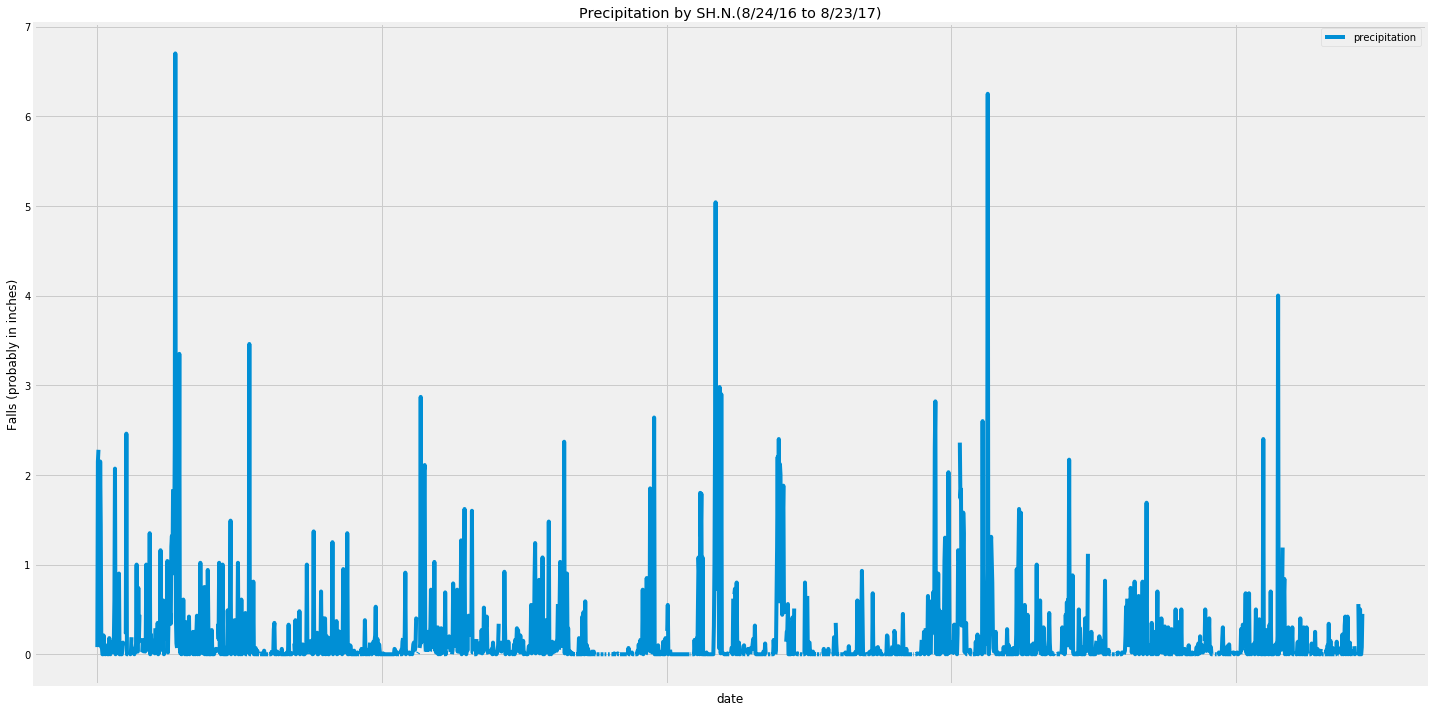

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates
prcp_df.plot('date', 'prcp', figsize=(20,10))
plt.xlabel("date")
plt.ylabel("Falls (probably in inches)")
plt.title("Precipitation by SH.N.(8/24/16 to 8/23/17)")
plt.legend(["precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# How many stations are available in this dataset?
total_stations = session.query(Measurement).group_by(Measurement.station).count()
print("Totally we have {} stations in this data source.".format(total_stations))

Totally we have 9 stations in this data source.


In [19]:
# What are the most active stations?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
                  group_by(Measurement.station).\
                  order_by(func.count(Measurement.tobs).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
the_most_active = active_stations[0][0]

observed_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
       filter(Measurement.station == the_most_active).all()
observed_temps

[(54.0, 85.0, 71.66378066378067)]

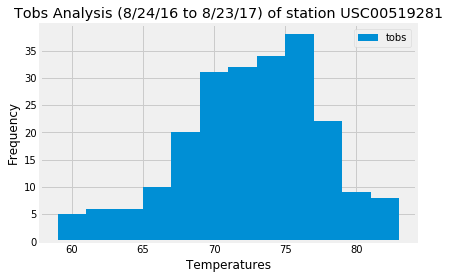

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

start_date = "2016-8-24"
end_date = "2017-8-23"

temps = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
        filter(Measurement.station == the_most_active).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        order_by(Measurement.date).all()

temp_df = pd.DataFrame(temps)

plt.hist(temp_df['tobs'],12)
plt.xlabel("Temperatures")
plt.ylabel("Frequency")
plt.title(f"Tobs Analysis (8/24/16 to 8/23/17) of station {the_most_active}")
plt.legend(["tobs"])
plt.show()

In [22]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Time is between June 2nd to June 9th 2017:

arrival_date = dt.date(2017, 6, 2)
departure_date = dt.date(2017, 6, 9)
all_temps = (calc_temps(arrival_date, departure_date))
all_temps

[(72.0, 77.75, 81.0)]

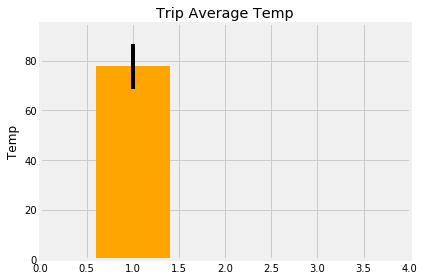

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_min = all_temps[0][0]
temp_avg = all_temps[0][1]
temp_max = all_temps[0][2]
p2p = all_temps[0][2]-all_temps[0][0]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , temp_avg, color= 'orange', yerr=p2p)
ax.set_ylabel("Temp")
ax.set_title("Trip Average Temp")
plt.ylim(0, 95)
plt.xlim(0,4)
fig.tight_layout()

In [25]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

arrival_date = dt.date(2017, 6, 2)
departure_date = dt.date(2017, 6, 9)

station_check = session.query(Station.station, Station.name, Station.latitude
                              , Station.longitude, Station.elevation, Measurement.prcp).\
    filter(Measurement.date >= arrival_date).\
    filter(Measurement.date <= departure_date).\
    order_by(Measurement.prcp.desc()).all()

print(station_check)

[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.82), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.82), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.82), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.82), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.82), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.82), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.82), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.82), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.82), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.2), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.2), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.2), ('USC00517948', 'PEARL CITY, HI US', 21.393

## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
          

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
